In [2]:
import pandas as pd

df = pd.read_csv('dataset_malwares.csv').set_index('Name')

In [3]:
def clean_useless_cols(df, y_label):
    print('#########################')
    print(f'starting with {df.columns.size} cols')
    print('#########################')
    print(df.corr().nlargest(df.columns.size, y_label)
          [y_label].sort_values(ascending=0))
    irrelevant_cols = pd.DataFrame(df.corr()[y_label]).isna()
    ir_cols_list = irrelevant_cols[irrelevant_cols[y_label]].index
    print('\n#########################')
    print('irrelevant cols found (constants):')
    print('#########################')
    print(df[ir_cols_list].nunique())
    df.drop(ir_cols_list, axis=1, inplace=True)
    print('\n#########################')
    print(f'voila! set cleared. {df.columns.size} cols left to work with')
    print('#########################')

from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay

def acc_confusion(clf,X,y):
    print('#########################')
    print(f'accuracy: {accuracy_score(y,clf.predict(X))}')
    print('#########################')
    ConfusionMatrixDisplay.from_estimator(clf,X,y)

In [4]:
clean_useless_cols(df, 'Malware')

#########################
starting with 78 cols
#########################
Malware                      1.000000
SectionMaxChar               0.393282
SizeOfStackReserve           0.251791
SuspiciousImportFunctions    0.216656
DllCharacteristics           0.197023
                               ...   
SectionMaxVirtualsize             NaN
SectionMinPhysical                NaN
SectionMinVirtual                 NaN
SectionMinPointerData             NaN
SectionMainChar                   NaN
Name: Malware, Length: 78, dtype: float64

#########################
irrelevant cols found (constants):
#########################
e_magic                  1
SectionMaxEntropy        1
SectionMaxRawsize        1
SectionMaxVirtualsize    1
SectionMinPhysical       1
SectionMinVirtual        1
SectionMinPointerData    1
SectionMainChar          1
dtype: int64

#########################
voila! set cleared. 70 cols left to work with
#########################


<Axes: >

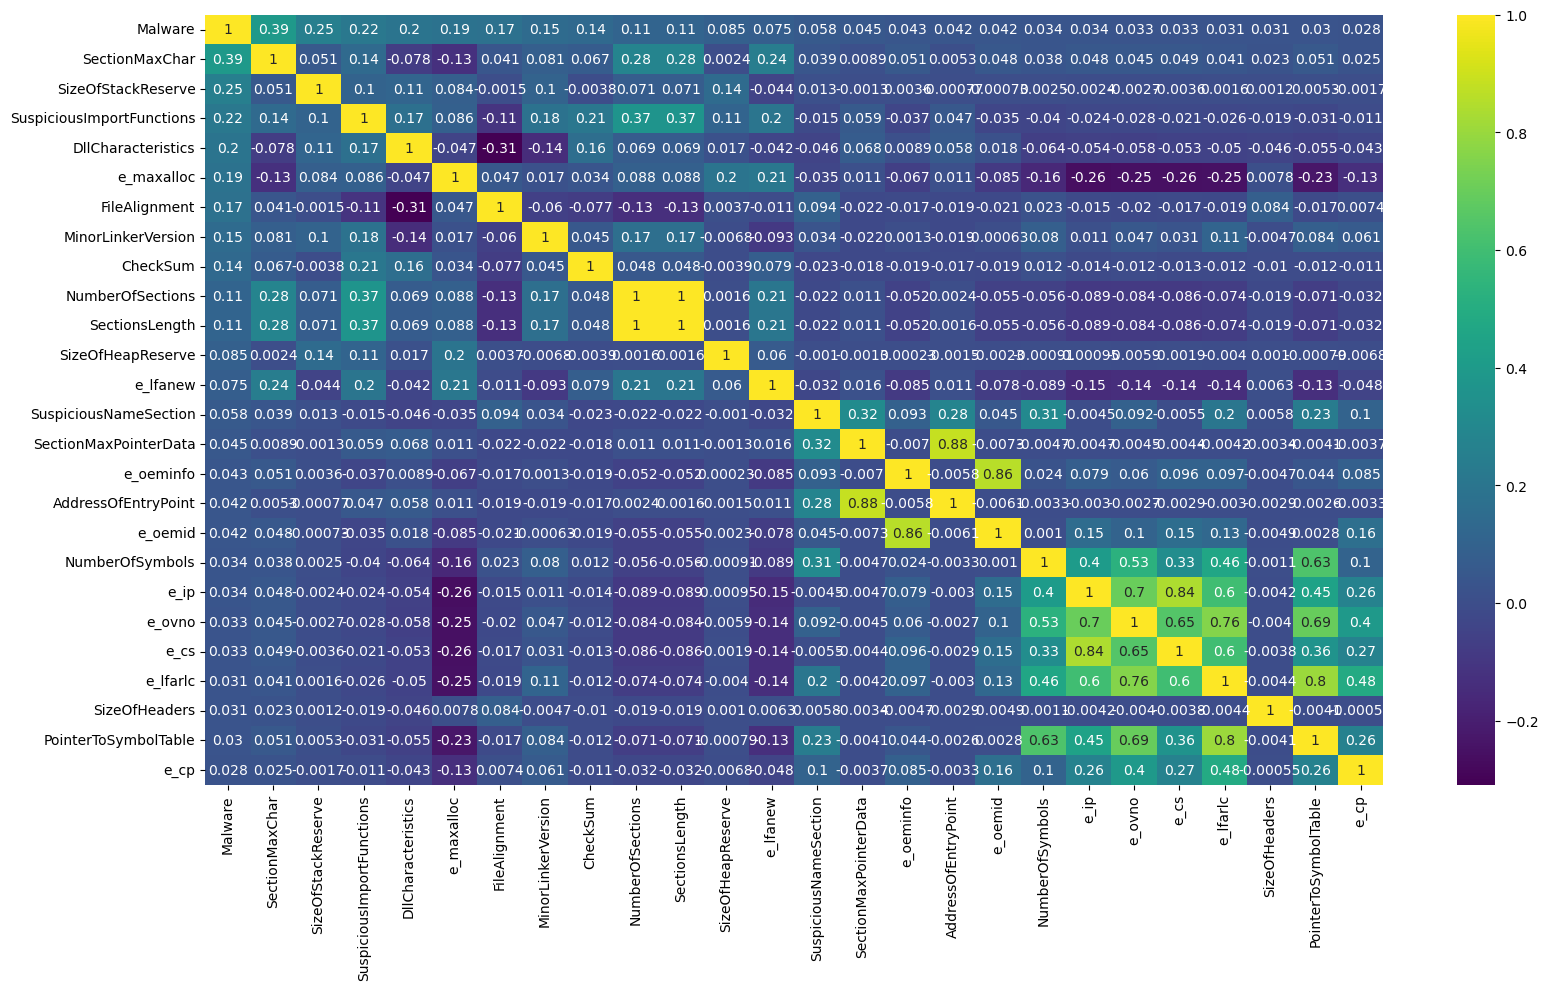

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(19,10),dpi=100)
cols = df.corr().nlargest(26, 'Malware')['Malware'].sort_values(ascending=0).index
sns.heatmap(df[cols].corr(),annot=True,cmap='viridis')

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2, RFE,RFECV
from sklearn.model_selection import train_test_split

clf = DecisionTreeClassifier(random_state=101)

OG_X = df.drop('Malware', axis=1)
y = df['Malware']

X_train, X_test, y_train, y_test = train_test_split(
    OG_X, y, random_state=101, shuffle=1, test_size=0.3, stratify=y)


In [7]:
# Possible feature selection
# KBest
skb = SelectKBest(chi2, k=5).fit(X_train, y_train)
# Recurrent Feature Extraction 
rfe = RFE(clf,step=1).fit(X_train,y_train)
# Recurrent Feature Extraction with Cross-Validation
rfecv = RFECV(clf,step=1,scoring='accuracy',cv=5).fit(X_train,y_train)

SKBX_train = skb.transform(X_train)
SKBX_test = skb.transform(X_test)
pd.DataFrame({'ft': OG_X.columns, 'score': skb.scores_}
             ).sort_values('score', ascending=0)
print(f'SKB OG ft: {X_train.shape[1:]} | best ft: {SKBX_train.shape[1:]}')

RFEX_train = rfe.transform(X_train)
RFEX_test = rfe.transform(X_test)
rfe_df = pd.DataFrame({'ft':OG_X.columns,'ranking':rfe.ranking_}).sort_values('ranking')
keep_ft = rfe_df.loc[rfe_df['ranking']<2,'ranking'].count()
print(f'RFE now considering {keep_ft} cols')

RFECVX_train = rfecv.transform(X_train)
RFECVX_test = rfecv.transform(X_test)
print(f'RFECV says {X_train.columns[rfecv.support_]} ({rfecv.n_features_}) as best ft\'s to keep')

SKB OG ft: (69,) | best ft: (5,)
RFE now considering 34 cols
RFECV says Index(['e_lfanew', 'TimeDateStamp', 'PointerToSymbolTable', 'Characteristics',
       'MajorLinkerVersion', 'MinorLinkerVersion', 'SizeOfCode',
       'SizeOfInitializedData', 'AddressOfEntryPoint', 'ImageBase',
       'MajorOperatingSystemVersion', 'MinorOperatingSystemVersion',
       'MajorImageVersion', 'MajorSubsystemVersion', 'SizeOfHeaders',
       'CheckSum', 'SizeOfImage', 'Subsystem', 'DllCharacteristics',
       'SizeOfStackReserve', 'SizeOfHeapReserve', 'SuspiciousImportFunctions',
       'SectionMinEntropy', 'SectionMinVirtualsize', 'SectionMaxPhysical',
       'SectionMaxVirtual', 'SectionMaxPointerData', 'SectionMaxChar',
       'DirectoryEntryImport', 'DirectoryEntryImportSize',
       'DirectoryEntryExport', 'ImageDirectoryEntryResource',
       'ImageDirectoryEntryException', 'ImageDirectoryEntrySecurity'],
      dtype='object') (34) as best ft's to keep


Text(0.5, 0, 'ft')

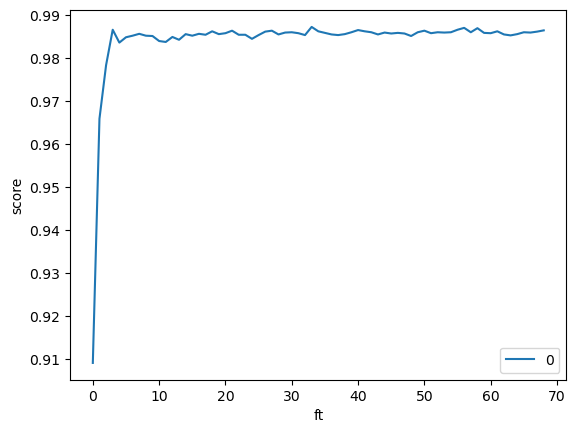

In [8]:
import numpy as np
# Understanding where RFE CV stopped
dfplot = pd.DataFrame(rfecv.cv_results_['mean_test_score']).plot()
# dfplot.set_xlim((0,16))
dfplot.set_ylabel('score')
dfplot.set_xlabel('ft')

#########################
accuracy: 0.9862338545207342
#########################
#########################
accuracy: 0.9865737593473828
#########################
#########################
accuracy: 0.9843643779741672
#########################
#########################
accuracy: 0.9843643779741672
#########################


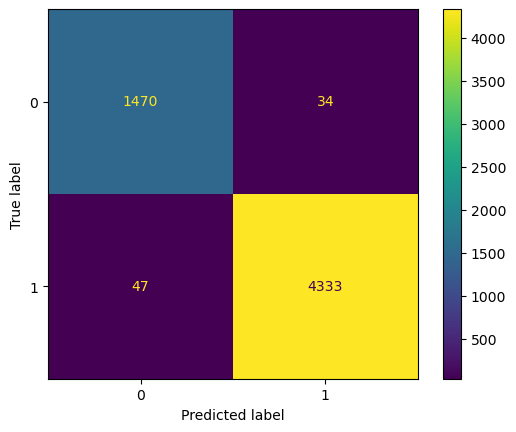

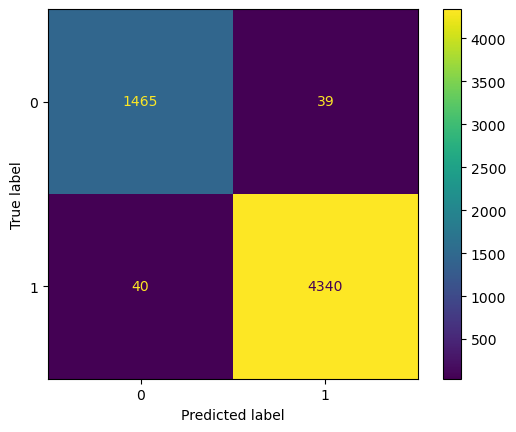

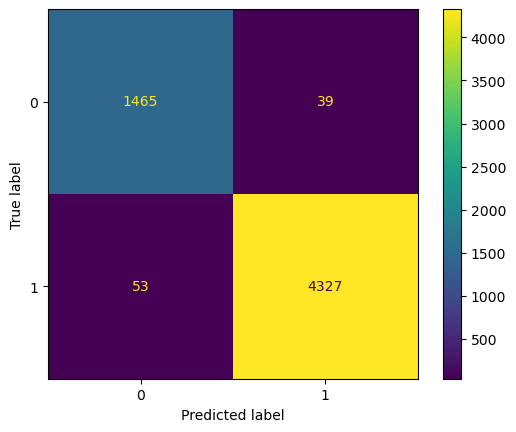

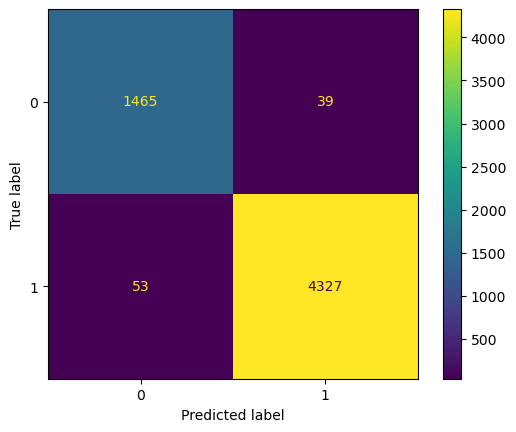

In [9]:
# Vanilla
clf.fit(X_train,y_train)
acc_confusion(clf,X_test,y_test)

# SKB
clf.fit(SKBX_train,y_train)
acc_confusion(clf,SKBX_test,y_test)

# RFE
clf.fit(RFEX_train,y_train)
acc_confusion(clf,RFEX_test,y_test)

# RFE with CV
clf.fit(RFECVX_train,y_train)
acc_confusion(clf,RFECVX_test,y_test)

In [13]:
# SKB
clf.fit(SKBX_train,y_train)
skb

array([0.43063826, 0.46030821, 0.05267138, 0.01352235, 0.0428598 ])

In [208]:
# Imbalance
df['Malware'].value_counts()

1    14599
0     5012
Name: Malware, dtype: int64